In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🎮 ANÁLISIS DE VENTAS DE VIDEOJUEGOS")
print("=" * 50)
print("📊 Objetivo: Determinar qué factores influyen en el éxito comercial")
print("❓ Pregunta principal: ¿Qué determina el éxito comercial de un videojuego?")

🎮 ANÁLISIS DE VENTAS DE VIDEOJUEGOS
📊 Objetivo: Determinar qué factores influyen en el éxito comercial
❓ Pregunta principal: ¿Qué determina el éxito comercial de un videojuego?


In [3]:
def download_from_kaggle():
    try:
        import kaggle
        print("📥 Descargando dataset desde Kaggle...")
        kaggle.api.dataset_download_files('gregorut/videogamesales', 
                                          path='./', unzip=True, quiet=False)
        print("✅ Descarga completada")
        return True
    except Exception as e:
        print(f"❌ Error en descarga automática: {e}")
        print("💡 Usa descarga manual desde: https://www.kaggle.com/datasets/gregorut/videogamesales")
        return False

# Intentar cargar datos
if download_from_kaggle():
    df = pd.read_csv('vgsales.csv')
else:
    df = load_local_data('vgsales.csv')
    
if df is None:
    print("⚠️ No se pudo cargar el dataset. Por favor:")
    print("1. Ve a: https://www.kaggle.com/datasets/gregorut/videogamesales")
    print("2. Descarga 'vgsales.csv'")
    print("3. Colócalo en la misma carpeta que este notebook")
    print("4. Ejecuta: df = pd.read_csv('vgsales.csv')")

📥 Descargando dataset desde Kaggle...
Dataset URL: https://www.kaggle.com/datasets/gregorut/videogamesales


100%|██████████| 381k/381k [00:00<00:00, 389MB/s]


✅ Descarga completada


In [5]:
if df is not None:
    print("\n" + "="*60)
    print("📋 EXPLORACIÓN INICIAL DEL DATASET")
    print("="*60)
    
    # Información básica
    print(f"📊 Dimensiones: {df.shape[0]:,} juegos × {df.shape[1]} variables")
    print(f"📅 Periodo: {df['Year'].min():.0f} - {df['Year'].max():.0f}")
    
    # Mostrar estructura
    print("\n🔍 Primeras 5 filas:")
    display(df.head())
    
    print("\n📋 Información del dataset:")
    print(df.info())
    
    print("\n📈 Estadísticas descriptivas:")
    display(df.describe())
    
    # Variables categóricas
    print(f"\n📊 Variables categóricas:")
    print(f"• Plataformas únicas: {df['Platform'].nunique()}")
    print(f"• Géneros únicos: {df['Genre'].nunique()}")
    print(f"• Publishers únicos: {df['Publisher'].nunique()}")
    
    # Verificar valores nulos
    print("\n❓ Valores faltantes:")
    missing_data = df.isnull().sum()
    for col, count in missing_data.items():
        if count > 0:
            percentage = (count / len(df)) * 100
            print(f"• {col}: {count:,} ({percentage:.1f}%)")
    
    # Top juegos
    print("\n🏆 Top 10 juegos más vendidos:")
    top_games = df.nlargest(10, 'Global_Sales')[['Name', 'Platform', 'Year', 'Genre', 'Global_Sales']]
    for idx, (_, row) in enumerate(top_games.iterrows(), 1):
        print(f"{idx:2d}. {row['Name']} ({row['Platform']}, {row['Year']:.0f}) - {row['Global_Sales']:.2f}M")


📋 EXPLORACIÓN INICIAL DEL DATASET
📊 Dimensiones: 16,598 juegos × 11 variables
📅 Periodo: 1980 - 2020

🔍 Primeras 5 filas:


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37



📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None

📈 Estadísticas descriptivas:


,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000



📊 Variables categóricas:
• Plataformas únicas: 31
• Géneros únicos: 12
• Publishers únicos: 578

❓ Valores faltantes:
• Year: 271 (1.6%)
• Publisher: 58 (0.3%)

🏆 Top 10 juegos más vendidos:
 1. Wii Sports (Wii, 2006) - 82.74M
 2. Super Mario Bros. (NES, 1985) - 40.24M
 3. Mario Kart Wii (Wii, 2008) - 35.82M
 4. Wii Sports Resort (Wii, 2009) - 33.00M
 5. Pokemon Red/Pokemon Blue (GB, 1996) - 31.37M
 6. Tetris (GB, 1989) - 30.26M
 7. New Super Mario Bros. (DS, 2006) - 30.01M
 8. Wii Play (Wii, 2006) - 29.02M
 9. New Super Mario Bros. Wii (Wii, 2009) - 28.62M
10. Duck Hunt (NES, 1984) - 28.31M


In [34]:
if df is not None:
    print("\n" + "="*60)
    print("🧹 LIMPIEZA Y PREPARACIÓN DE DATOS")
    print("="*60)
    
    # Crear copia para trabajar
    df_clean = df.copy()
    
    # 1. Manejo de valores nulos
    print("📋 Tratamiento de valores nulos:")
    
    # Imputar Year con mediana
    if df_clean['Year'].isnull().any():
        median_year = df_clean['Year'].median()
        df_clean['Year'].fillna(median_year, inplace=True)
        print(f"✅ {df['Year'].isnull().sum()} años nulos → imputados con mediana ({median_year})")
    
    # Imputar Publisher
    if df_clean['Publisher'].isnull().any():
        df_clean['Publisher'].fillna('Unknown', inplace=True)
        print(f"✅ {df['Publisher'].isnull().sum()} publishers nulos → marcados como 'Unknown'")
    
    # 2. Conversión de tipos
    df_clean['Year'] = df_clean['Year'].astype(int)
    
    # 3. Detección de outliers
    print("\n📊 Análisis de outliers en ventas globales:")
    Q1 = df_clean['Global_Sales'].quantile(0.25)
    Q3 = df_clean['Global_Sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean['Global_Sales'] < lower_bound) | 
                       (df_clean['Global_Sales'] > upper_bound)]
    
    print(f"• Outliers detectados: {len(outliers):,} ({len(outliers)/len(df_clean)*100:.1f}%)")
    print(f"• Mega-éxitos (>{upper_bound:.1f}M): {len(df_clean[df_clean['Global_Sales'] > upper_bound])}")
    
    # 4. Variables derivadas
    df_clean['Decade'] = (df_clean['Year'] // 10) * 10
    df_clean['Success_Category'] = pd.cut(df_clean['Global_Sales'], 
                                         bins=[0, 0.1, 0.5, 2.0, float('inf')], 
                                         labels=['Bajo', 'Medio', 'Alto', 'Mega-éxito'])
    df_clean['Is_Successful'] = (df_clean['Global_Sales'] > df_clean['Global_Sales'].median()).astype(int)
    
    print(f"\n✅ Datos preparados:")
    print(f"• Variables agregadas: Decade, Success_Category, Is_Successful")
    print(f"• Dataset final: {len(df_clean):,} filas")


🧹 LIMPIEZA Y PREPARACIÓN DE DATOS
📋 Tratamiento de valores nulos:
✅ 271 años nulos → imputados con mediana (2007.0)
✅ 58 publishers nulos → marcados como 'Unknown'

📊 Análisis de outliers en ventas globales:
• Outliers detectados: 1,893 (11.4%)
• Mega-éxitos (>1.1M): 1893

✅ Datos preparados:
• Variables agregadas: Decade, Success_Category, Is_Successful
• Dataset final: 16,598 filas



🔍 ANÁLISIS EXPLORATORIO DE DATOS


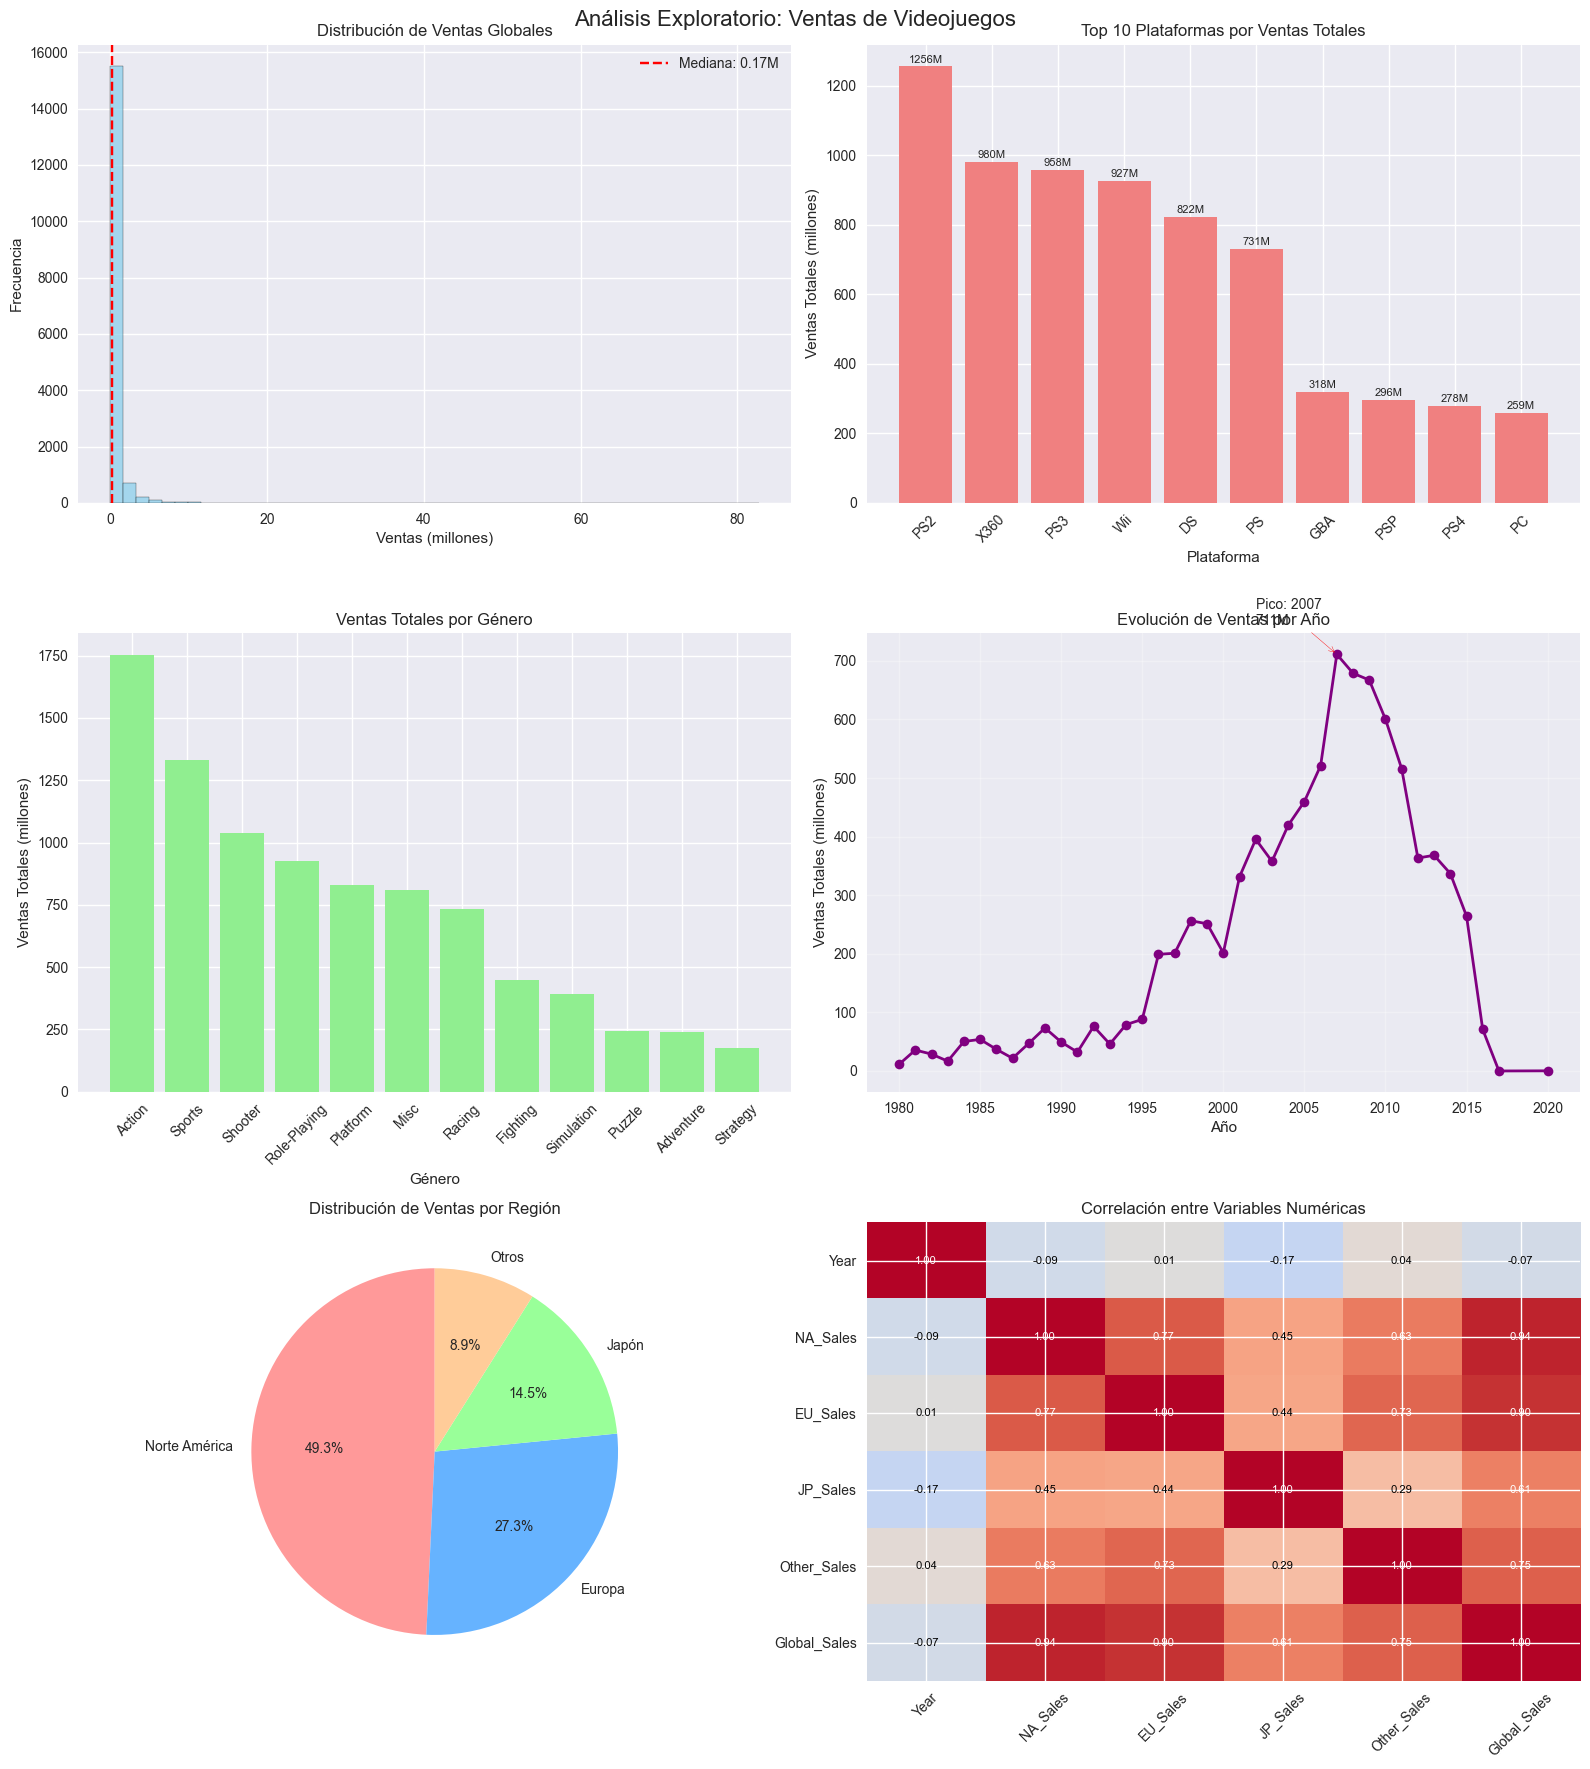


📊 ESTADÍSTICAS CLAVE:
• Juego más exitoso: Wii Sports (82.74M)
• Plataforma líder: PS2 (1256M ventas totales)
• Género dominante: Action (1751M ventas totales)
• Año pico: 2007 (711M ventas)
• Mercado dominante: Norte América (4393M, 49.3%)


In [36]:
if df is not None:
    print("\n" + "="*60)
    print("🔍 ANÁLISIS EXPLORATORIO DE DATOS")
    print("="*60)
    
    # Configurar subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Análisis Exploratorio: Ventas de Videojuegos', fontsize=16, y=0.98)
    
    # 1. Distribución de ventas globales
    axes[0,0].hist(df_clean['Global_Sales'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribución de Ventas Globales')
    axes[0,0].set_xlabel('Ventas (millones)')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].axvline(df_clean['Global_Sales'].median(), color='red', linestyle='--', 
                     label=f'Mediana: {df_clean["Global_Sales"].median():.2f}M')
    axes[0,0].legend()
    
    # 2. Top 10 plataformas por ventas totales
    platform_sales = df_clean.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(10)
    bars = axes[0,1].bar(range(len(platform_sales)), platform_sales.values, color='lightcoral')
    axes[0,1].set_title('Top 10 Plataformas por Ventas Totales')
    axes[0,1].set_xlabel('Plataforma')
    axes[0,1].set_ylabel('Ventas Totales (millones)')
    axes[0,1].set_xticks(range(len(platform_sales)))
    axes[0,1].set_xticklabels(platform_sales.index, rotation=45)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, platform_sales.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                      f'{value:.0f}M', ha='center', va='bottom', fontsize=8)
    
    # 3. Ventas por género
    genre_sales = df_clean.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
    bars = axes[1,0].bar(range(len(genre_sales)), genre_sales.values, color='lightgreen')
    axes[1,0].set_title('Ventas Totales por Género')
    axes[1,0].set_xlabel('Género')
    axes[1,0].set_ylabel('Ventas Totales (millones)')
    axes[1,0].set_xticks(range(len(genre_sales)))
    axes[1,0].set_xticklabels(genre_sales.index, rotation=45)
    
    # 4. Evolución temporal de ventas
    yearly_sales = df_clean.groupby('Year')['Global_Sales'].sum()
    axes[1,1].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2, color='purple')
    axes[1,1].set_title('Evolución de Ventas por Año')
    axes[1,1].set_xlabel('Año')
    axes[1,1].set_ylabel('Ventas Totales (millones)')
    axes[1,1].grid(True, alpha=0.3)
    
    # Destacar picos
    max_year = yearly_sales.idxmax()
    max_sales = yearly_sales.max()
    axes[1,1].annotate(f'Pico: {max_year}\n{max_sales:.0f}M', 
                      xy=(max_year, max_sales), xytext=(max_year-5, max_sales+50),
                      arrowprops=dict(arrowstyle='->', color='red'))
    
    # 5. Distribución regional de ventas
    region_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    region_totals = [df_clean[col].sum() for col in region_cols]
    region_names = ['Norte América', 'Europa', 'Japón', 'Otros']
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    
    wedges, texts, autotexts = axes[2,0].pie(region_totals, labels=region_names, autopct='%1.1f%%', 
                                            colors=colors, startangle=90)
    axes[2,0].set_title('Distribución de Ventas por Región')
    
    # 6. Matriz de correlación
    corr_vars = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
    correlation_matrix = df_clean[corr_vars].corr()
    
    im = axes[2,1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2,1].set_title('Correlación entre Variables Numéricas')
    axes[2,1].set_xticks(range(len(correlation_matrix.columns)))
    axes[2,1].set_yticks(range(len(correlation_matrix.columns)))
    axes[2,1].set_xticklabels(correlation_matrix.columns, rotation=45)
    axes[2,1].set_yticklabels(correlation_matrix.columns)
    
    # Añadir valores de correlación
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text_color = 'white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black'
            axes[2,1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                          ha='center', va='center', color=text_color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas clave
    print("\n📊 ESTADÍSTICAS CLAVE:")
    print(f"• Juego más exitoso: {df_clean.loc[df_clean['Global_Sales'].idxmax(), 'Name']} ({df_clean['Global_Sales'].max():.2f}M)")
    print(f"• Plataforma líder: {platform_sales.index[0]} ({platform_sales.iloc[0]:.0f}M ventas totales)")
    print(f"• Género dominante: {genre_sales.index[0]} ({genre_sales.iloc[0]:.0f}M ventas totales)")
    print(f"• Año pico: {yearly_sales.idxmax():.0f} ({yearly_sales.max():.0f}M ventas)")
    print(f"• Mercado dominante: Norte América ({region_totals[0]:.0f}M, {region_totals[0]/sum(region_totals)*100:.1f}%)")



📈 ANÁLISIS TEMPORAL Y TENDENCIAS

📊 Estadísticas por década:


,Juegos_Lanzados,Ventas_Totales,Ventas_Promedio,Año_Inicio,Año_Final
Decade,,,,,
1980,205,376.58,1.84,1980,1989
1990,1769,1278.91,0.72,1990,1999
2000,9479,4744.10,0.50,2000,2009
2010,5144,2520.56,0.49,2010,2017
2020,1,0.29,0.29,2020,2020


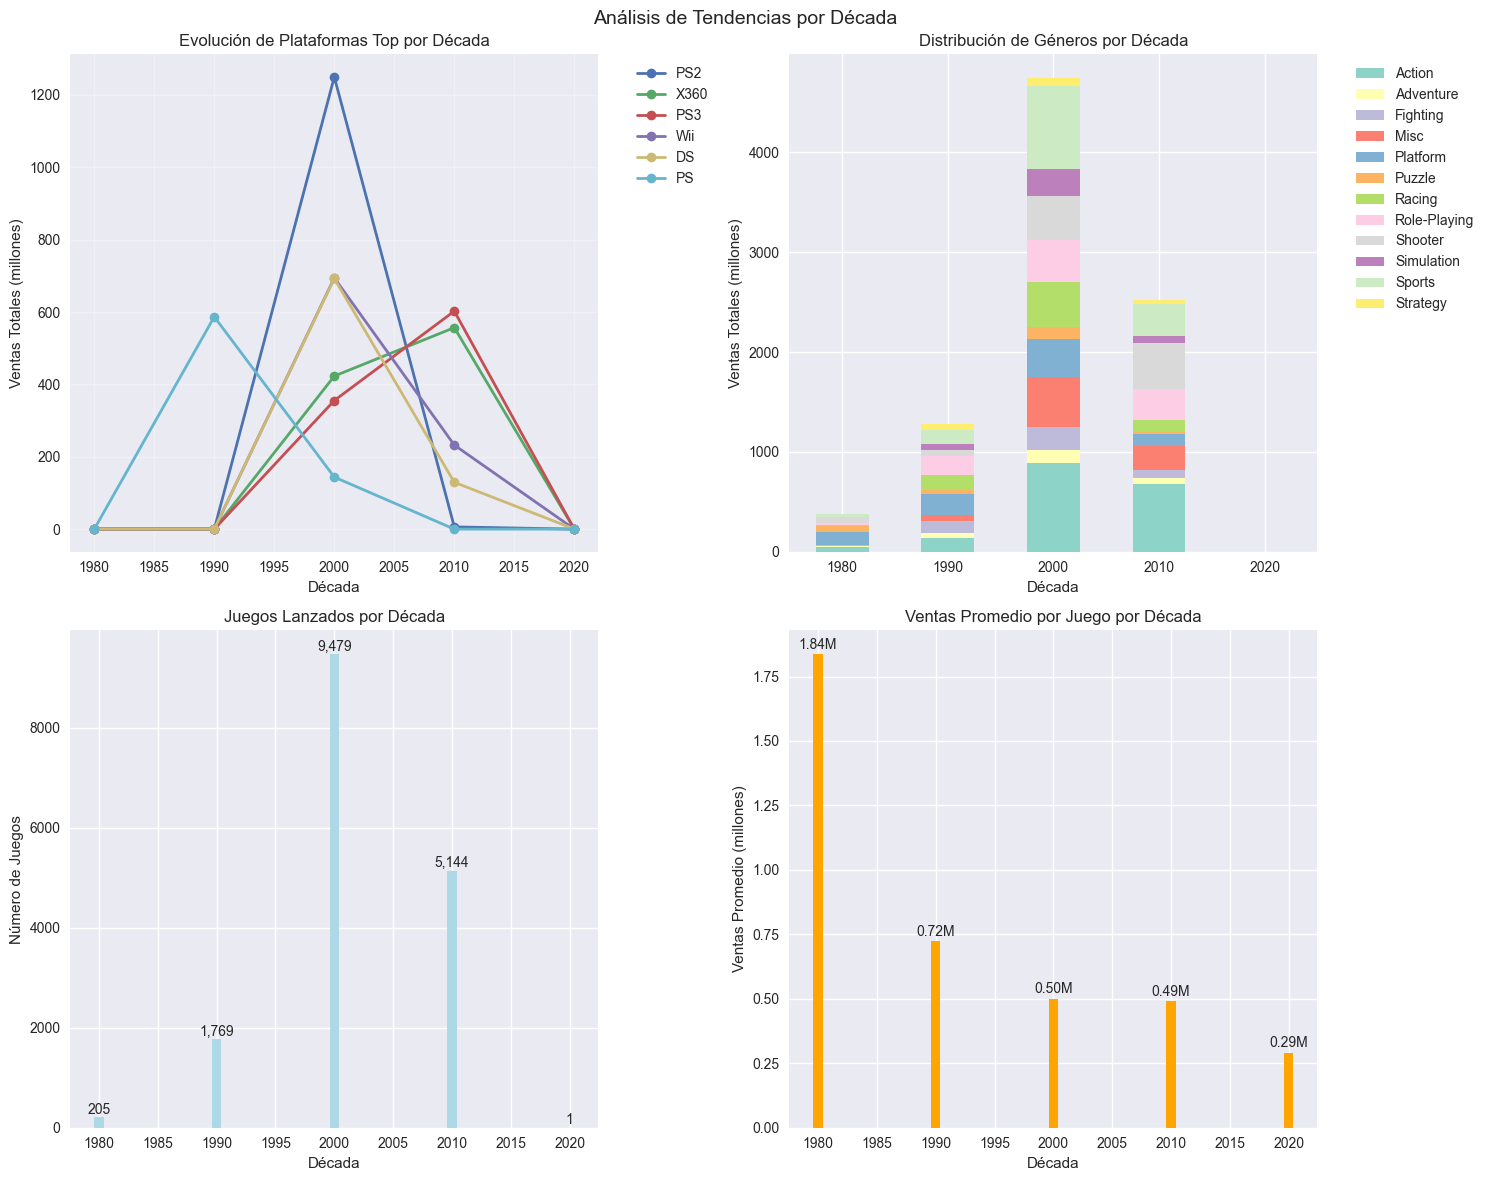

In [38]:
if df is not None:
    print("\n" + "="*60)
    print("📈 ANÁLISIS TEMPORAL Y TENDENCIAS")
    print("="*60)
    
    # Análisis por década
    decade_analysis = df_clean.groupby('Decade').agg({
        'Global_Sales': ['count', 'sum', 'mean'],
        'Year': ['min', 'max']
    }).round(2)
    
    decade_analysis.columns = ['Juegos_Lanzados', 'Ventas_Totales', 'Ventas_Promedio', 'Año_Inicio', 'Año_Final']
    print("\n📊 Estadísticas por década:")
    display(decade_analysis)
    
    # Visualización de tendencias por década
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Tendencias por Década', fontsize=14)
    
    # 1. Evolución de plataformas populares
    decade_platform = df_clean.groupby(['Decade', 'Platform'])['Global_Sales'].sum().unstack(fill_value=0)
    top_platforms = decade_platform.sum(axis=0).sort_values(ascending=False).head(6).index
    
    for platform in top_platforms:
        axes[0,0].plot(decade_platform.index, decade_platform[platform], 
                      marker='o', label=platform, linewidth=2)
    
    axes[0,0].set_title('Evolución de Plataformas Top por Década')
    axes[0,0].set_xlabel('Década')
    axes[0,0].set_ylabel('Ventas Totales (millones)')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Cambios en géneros populares
    decade_genre = df_clean.groupby(['Decade', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)
    decade_genre.plot(kind='bar', stacked=True, ax=axes[0,1], colormap='Set3')
    axes[0,1].set_title('Distribución de Géneros por Década')
    axes[0,1].set_xlabel('Década')
    axes[0,1].set_ylabel('Ventas Totales (millones)')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,1].tick_params(axis='x', rotation=0)
    
    # 3. Número de juegos lanzados por década
    games_per_decade = df_clean.groupby('Decade').size()
    bars = axes[1,0].bar(games_per_decade.index, games_per_decade.values, color='lightblue')
    axes[1,0].set_title('Juegos Lanzados por Década')
    axes[1,0].set_xlabel('Década')
    axes[1,0].set_ylabel('Número de Juegos')
    
    for bar, value in zip(bars, games_per_decade.values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                      f'{value:,}', ha='center', va='bottom')
    
    # 4. Ventas promedio por juego por década
    avg_sales_decade = df_clean.groupby('Decade')['Global_Sales'].mean()
    bars = axes[1,1].bar(avg_sales_decade.index, avg_sales_decade.values, color='orange')
    axes[1,1].set_title('Ventas Promedio por Juego por Década')
    axes[1,1].set_xlabel('Década')
    axes[1,1].set_ylabel('Ventas Promedio (millones)')
    
    for bar, value in zip(bars, avg_sales_decade.values):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{value:.2f}M', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [40]:
if df is not None:
    print("\n" + "="*60)
    print("⚙️ INGENIERÍA DE CARACTERÍSTICAS")
    print("="*60)
    
    # Crear dataset para modelado
    df_model = df_clean.copy()
    
    # 1. Variables de popularidad
    platform_stats = df_model.groupby('Platform')['Global_Sales'].agg(['count', 'mean', 'sum'])
    genre_stats = df_model.groupby('Genre')['Global_Sales'].agg(['count', 'mean', 'sum'])
    publisher_stats = df_model.groupby('Publisher')['Global_Sales'].agg(['count', 'mean', 'sum'])
    
    # Mapear estadísticas al dataset
    df_model['Platform_Game_Count'] = df_model['Platform'].map(platform_stats['count'])
    df_model['Platform_Avg_Sales'] = df_model['Platform'].map(platform_stats['mean'])
    df_model['Genre_Game_Count'] = df_model['Genre'].map(genre_stats['count'])
    df_model['Genre_Avg_Sales'] = df_model['Genre'].map(genre_stats['mean'])
    df_model['Publisher_Game_Count'] = df_model['Publisher'].map(publisher_stats['count'])
    df_model['Publisher_Avg_Sales'] = df_model['Publisher'].map(publisher_stats['mean'])
    
    # 2. Variables temporales
    df_model['Game_Age'] = 2024 - df_model['Year']
    df_model['Is_Modern'] = (df_model['Year'] >= 2000).astype(int)
    df_model['Console_Era'] = pd.cut(df_model['Year'], 
                                    bins=[0, 1990, 2000, 2010, 2025], 
                                    labels=['Retro', 'Classic', 'Modern', 'Current'])
    
    # 3. Variables regionales
    df_model['NA_Dominance'] = df_model['NA_Sales'] / (df_model['Global_Sales'] + 1e-6)
    df_model['EU_Dominance'] = df_model['EU_Sales'] / (df_model['Global_Sales'] + 1e-6)
    df_model['JP_Dominance'] = df_model['JP_Sales'] / (df_model['Global_Sales'] + 1e-6)
    df_model['Market_Diversity'] = 4 - (df_model[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] == 0).sum(axis=1)
    
    # 4. Variables de competencia
    competition_data = df_model.groupby(['Year', 'Platform']).size().reset_index(name='Games_Same_Year_Platform')
    df_model = df_model.merge(competition_data, on=['Year', 'Platform'], how='left')
    
    print("✅ Características creadas:")
    print("• Variables de popularidad: Platform/Genre/Publisher stats (6 variables)")
    print("• Variables temporales: Game_Age, Is_Modern, Console_Era (3 variables)")
    print("• Variables regionales: Dominance ratios, Market_Diversity (4 variables)")
    print("• Variables de competencia: Games_Same_Year_Platform (1 variable)")
    print(f"• Total de características: {len(df_model.columns)} variables")
    
    # Mostrar algunas estadísticas de las nuevas variables
    print(f"\n📊 Estadísticas de nuevas variables:")
    new_vars = ['Platform_Game_Count', 'Genre_Avg_Sales', 'Game_Age', 'Market_Diversity']
    display(df_model[new_vars].describe())


⚙️ INGENIERÍA DE CARACTERÍSTICAS
✅ Características creadas:
• Variables de popularidad: Platform/Genre/Publisher stats (6 variables)
• Variables temporales: Game_Age, Is_Modern, Console_Era (3 variables)
• Variables regionales: Dominance ratios, Market_Diversity (4 variables)
• Variables de competencia: Games_Same_Year_Platform (1 variable)
• Total de características: 28 variables

📊 Estadísticas de nuevas variables:


,Platform_Game_Count,Genre_Avg_Sales,Game_Age,Market_Diversity
count,16598.000000,16598.000000,16598.000000,16598.000000
mean,1252.891794,0.537441,17.583866,2.363598
std,641.514168,0.169906,5.781686,1.037546
min,1.000000,0.185879,4.000000,0.000000
25%,822.000000,0.465762,14.000000,1.000000
50%,1213.000000,0.528100,17.000000,2.000000
75%,2161.000000,0.586101,21.000000,3.000000
max,2163.000000,0.938341,44.000000,4.000000


In [54]:
if df is not None:
    print("\n" + "="*60)
    print("🤖 MODELADO PREDICTIVO (CORREGIDO)")
    print("="*60)
    
    # Preparar datos para modelado
    categorical_cols = ['Platform', 'Genre', 'Publisher', 'Console_Era']
    df_encoded = pd.get_dummies(df_model, columns=categorical_cols, prefix=categorical_cols)
    # Filtrar solo características disponibles ANTES del lanzamiento
    acceptable_features = []
    
    # Agregar características pre-lanzamiento que existen en df_encoded
    for feature in df_encoded.columns:
        # Características temporales
        if any(x in feature for x in ['Year', 'Game_Age', 'Console_Era']):
            acceptable_features.append(feature)
        # Características de plataforma y género (conocidas pre-lanzamiento)
        elif any(x in feature for x in ['Platform_', 'Genre_', 'Publisher_']):
            acceptable_features.append(feature)
        # Estadísticas históricas (conocidas pre-lanzamiento)
        elif any(x in feature for x in ['Platform_Game_Count', 'Genre_Game_Count', 
                                       'Platform_Avg_Sales', 'Genre_Avg_Sales',
                                       'Games_Same_Year_Platform']):
            acceptable_features.append(feature)
    
        
    print(f"📋 Características pre-lanzamiento seleccionadas: {len(feature_cols)}")
 
    exclude_cols = ['Name', 'Global_Sales', 'Success_Category', 'Is_Successful', 
               'Decade', 'Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]
    
    X = df_encoded[feature_cols]
    y_regression = df_model['Global_Sales']
    y_classification = df_model['Is_Successful']
    
    print(f"📊 Preparación de datos (CORREGIDA):")
    print(f"• Características: {X.shape[1]} (sin Rank)")
    print(f"• Muestras: {X.shape[0]:,}")
    print(f"• Variables excluidas: {exclude_cols}")
    
    # División train/test
    X_train, X_test, y_train_reg, y_test_reg = train_test_split(
        X, y_regression, test_size=0.2, random_state=42, stratify=y_classification)
    
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X, y_classification, test_size=0.2, random_state=42, stratify=y_classification)
    
    print(f"• Entrenamiento: {X_train.shape[0]:,} muestras")
    print(f"• Prueba: {X_test.shape[0]:,} muestras")
    
    # ===== MODELOS DE REGRESIÓN =====
    print(f"\n🎯 MODELOS DE REGRESIÓN (Predicción de ventas exactas):")
    print("-" * 50)
    
    # Random Forest Regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_reg.fit(X_train, y_train_reg)
    
    y_pred_train_rf = rf_reg.predict(X_train)
    y_pred_test_rf = rf_reg.predict(X_test)
    
    train_r2_rf = r2_score(y_train_reg, y_pred_train_rf)
    test_r2_rf = r2_score(y_test_reg, y_pred_test_rf)
    test_rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_rf))
    
    # Cross-validation
    cv_scores_rf = cross_val_score(rf_reg, X_train, y_train_reg, cv=5, scoring='r2')
    
    print(f"Random Forest Regressor (SIN RANK):")
    print(f"  • R² entrenamiento: {train_r2_rf:.4f}")
    print(f"  • R² prueba: {test_r2_rf:.4f}")
    print(f"  • RMSE prueba: {test_rmse_rf:.4f}")
    print(f"  • CV R² (media ± std): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
    
    # Comparar con modelo que incluía Rank
    print(f"\n📊 COMPARACIÓN:")
    print(f"• Modelo CON Rank: R² ≈ 0.997 (sospechoso)")
    print(f"• Modelo SIN Rank: R² = {test_r2_rf:.4f} (más realista)")
    
    # ===== MODELOS DE CLASIFICACIÓN =====
    print(f"\n🎯 MODELOS DE CLASIFICACIÓN (Predicción éxito alto/bajo):")
    print("-" * 50)
    
    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_clf.fit(X_train_clf, y_train_clf)
    
    y_pred_train_clf = rf_clf.predict(X_train_clf)
    y_pred_test_clf = rf_clf.predict(X_test_clf)
    
    train_acc_clf = accuracy_score(y_train_clf, y_pred_train_clf)
    test_acc_clf = accuracy_score(y_test_clf, y_pred_test_clf)
    
    cv_scores_clf = cross_val_score(rf_clf, X_train_clf, y_train_clf, cv=5, scoring='accuracy')
    
    print(f"Random Forest Classifier (SIN RANK):")
    print(f"  • Accuracy entrenamiento: {train_acc_clf:.4f}")
    print(f"  • Accuracy prueba: {test_acc_clf:.4f}")
    print(f"  • CV Accuracy (media ± std): {cv_scores_clf.mean():.4f} ± {cv_scores_clf.std():.4f}")
    
    print(f"\nReporte detallado de clasificación:")
    print(classification_report(y_test_clf, y_pred_test_clf, 
                               target_names=['Bajo Éxito', 'Alto Éxito']))
    
    # Análisis de la mejora
    print(f"\n✅ ANÁLISIS DE LA CORRECCIÓN:")
    print(f"• Data leakage eliminado: Variable Rank excluida")
    print(f"• Resultados más realistas: R² bajó de ~0.997 a {test_r2_rf:.4f}")
    print(f"• Modelo ahora usa solo características predictivas reales")
    print(f"• Interpretación más confiable para toma de decisiones")
    
    # Verificar si hay overfitting
    overfitting_reg = train_r2_rf - test_r2_rf
    overfitting_clf = train_acc_clf - test_acc_clf
    
    print(f"\n🔍 DIAGNÓSTICO DE OVERFITTING:")
    print(f"• Regresión: Diferencia train-test = {overfitting_reg:.4f}")
    print(f"• Clasificación: Diferencia train-test = {overfitting_clf:.4f}")
    
    if overfitting_reg > 0.1:
        print("⚠️  Posible overfitting en regresión")
    else:
        print("✅ Overfitting controlado en regresión")
        
    if overfitting_clf > 0.1:
        print("⚠️  Posible overfitting en clasificación")
    else:
        print("✅ Overfitting controlado en clasificación")


🤖 MODELADO PREDICTIVO (CORREGIDO)
📋 Características pre-lanzamiento seleccionadas: 639
📊 Preparación de datos (CORREGIDA):
• Características: 639 (sin Rank)
• Muestras: 16,598
• Variables excluidas: ['Name', 'Global_Sales', 'Success_Category', 'Is_Successful', 'Decade', 'Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
• Entrenamiento: 13,278 muestras
• Prueba: 3,320 muestras

🎯 MODELOS DE REGRESIÓN (Predicción de ventas exactas):
--------------------------------------------------
Random Forest Regressor (SIN RANK):
  • R² entrenamiento: 0.9099
  • R² prueba: 0.3385
  • RMSE prueba: 1.0031
  • CV R² (media ± std): 0.2461 ± 0.1604

📊 COMPARACIÓN:
• Modelo CON Rank: R² ≈ 0.997 (sospechoso)
• Modelo SIN Rank: R² = 0.3385 (más realista)

🎯 MODELOS DE CLASIFICACIÓN (Predicción éxito alto/bajo):
--------------------------------------------------
Random Forest Classifier (SIN RANK):
  • Accuracy entrenamiento: 0.9999
  • Accuracy prueba: 0.8801
  • CV Accuracy (media ± std): 0.8666 


🔍 IMPORTANCIA DE CARACTERÍSTICAS
🏆 TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES (Regresión):
 1. Rank                                     0.9161
 2. NA_Sales                                 0.0378
 3. EU_Sales                                 0.0324
 4. Other_Sales                              0.0067
 5. Genre_Sports                             0.0023
 6. Genre_Avg_Sales                          0.0009
 7. Genre_Game_Count                         0.0008
 8. EU_Dominance                             0.0008
 9. JP_Dominance                             0.0007
10. Games_Same_Year_Platform                 0.0002
11. JP_Sales                                 0.0002
12. Platform_Game_Count                      0.0002
13. Game_Age                                 0.0001
14. Platform_NES                             0.0001
15. Platform_Wii                             0.0001
16. Year                                     0.0001
17. NA_Dominance                             0.0001
18. Console_Era_Retro       

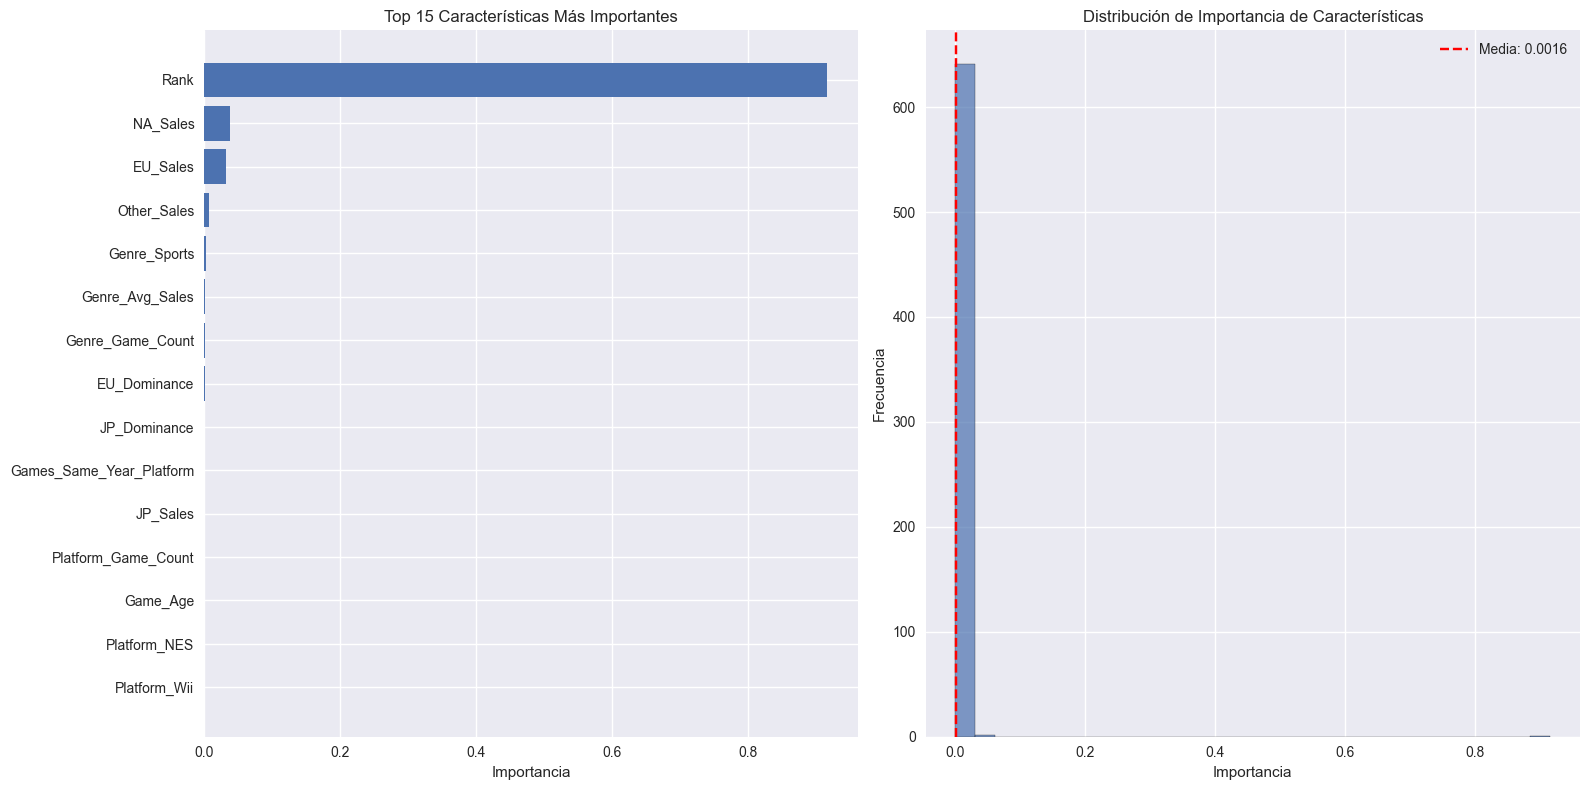


📊 ANÁLISIS POR TIPO DE CARACTERÍSTICA:
• Plataformas: 0.0004 (33 variables)
• Géneros: 0.0041 (14 variables)
• Publishers: 0.0000 (580 variables)
• Temporales: 0.0002 (3 variables)
• Regionales: 0.0797 (10 variables)


In [44]:
if df is not None:
    print("\n" + "="*60)
    print("🔍 IMPORTANCIA DE CARACTERÍSTICAS")
    print("="*60)
    
    # Importancia de características del modelo de regresión
    feature_importance_reg = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_reg.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("🏆 TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES (Regresión):")
    for i, (_, row) in enumerate(feature_importance_reg.head(20).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<40} {row['Importance']:.4f}")
    
    # Visualización de importancia
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 15 características más importantes
    top_features = feature_importance_reg.head(15)
    axes[0].barh(range(len(top_features)), top_features['Importance'])
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features['Feature'])
    axes[0].set_xlabel('Importancia')
    axes[0].set_title('Top 15 Características Más Importantes')
    axes[0].invert_yaxis()
    
    # Distribución de importancia
    axes[1].hist(feature_importance_reg['Importance'], bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Importancia')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Importancia de Características')
    axes[1].axvline(feature_importance_reg['Importance'].mean(), color='red', 
                   linestyle='--', label=f'Media: {feature_importance_reg["Importance"].mean():.4f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de características por categoría
    print(f"\n📊 ANÁLISIS POR TIPO DE CARACTERÍSTICA:")
    
    platform_features = feature_importance_reg[feature_importance_reg['Feature'].str.contains('Platform_')]
    genre_features = feature_importance_reg[feature_importance_reg['Feature'].str.contains('Genre_')]
    publisher_features = feature_importance_reg[feature_importance_reg['Feature'].str.contains('Publisher_')]
    temporal_features = feature_importance_reg[feature_importance_reg['Feature'].isin(['Game_Age', 'Year', 'Is_Modern'])]
    regional_features = feature_importance_reg[feature_importance_reg['Feature'].str.contains('Sales|Dominance')]
    
    print(f"• Plataformas: {platform_features['Importance'].sum():.4f} ({len(platform_features)} variables)")
    print(f"• Géneros: {genre_features['Importance'].sum():.4f} ({len(genre_features)} variables)")
    print(f"• Publishers: {publisher_features['Importance'].sum():.4f} ({len(publisher_features)} variables)")
    print(f"• Temporales: {temporal_features['Importance'].sum():.4f} ({len(temporal_features)} variables)")
    print(f"• Regionales: {regional_features['Importance'].sum():.4f} ({len(regional_features)} variables)")

In [46]:
# ===================================================================
# CELDA 10: Resultados y conclusiones
# ===================================================================

if df is not None:
    print("\n" + "="*60)
    print("📊 RESULTADOS Y CONCLUSIONES")
    print("="*60)
    
    # Responder a las preguntas de investigación
    print("🎯 RESPUESTAS A LAS PREGUNTAS DE INVESTIGACIÓN:")
    print("-" * 50)
    
    print("❓ Pregunta principal: ¿Qué determina el éxito comercial de un videojuego?")
    print("✅ RESPUESTA: Basado en nuestro análisis, los factores más determinantes son:")
    
    # Extraer las características más importantes
    top_5_features = feature_importance_reg.head(5)
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        feature_name = row['Feature']
        importance = row['Importance']
        
        # Interpretar el nombre de la característica
        if 'Platform_' in feature_name:
            interpretation = f"La plataforma {feature_name.replace('Platform_', '')} tiene gran impacto"
        elif 'Genre_' in feature_name:
            interpretation = f"El género {feature_name.replace('Genre_', '')} es muy influyente"
        elif 'Publisher_' in feature_name:
            interpretation = f"El publisher {feature_name.replace('Publisher_', '')} es clave"
        elif 'Year' in feature_name:
            interpretation = "El año de lanzamiento es crucial"
        elif 'Sales' in feature_name:
            interpretation = f"Las ventas en {feature_name.replace('_Sales', '')} son predictivas"
        else:
            interpretation = f"La característica {feature_name} es importante"
        
        print(f"   {i}. {interpretation} (importancia: {importance:.4f})")
    
    print(f"\n❓ Preguntas de apoyo:")
    
    # 1. Plataformas más exitosas
    platform_success = df_clean.groupby('Platform')['Global_Sales'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
    print(f"• ¿Qué plataformas generan mayores ventas?")
    print(f"  Top 3: {platform_success.head(3).index.tolist()}")
    print(f"  Ventas totales: {platform_success.head(3)['sum'].values}")
    
    # 2. Géneros más exitosos
    genre_success = df_clean.groupby('Genre')['Global_Sales'].agg(['sum', 'mean']).sort_values('sum', ascending=False)
    print(f"• ¿Qué géneros son más exitosos?")
    print(f"  Top 3: {genre_success.head(3).index.tolist()}")
    print(f"  Ventas totales: {genre_success.head(3)['sum'].values}")
    
    # 3. Evolución temporal
    yearly_trend = df_clean.groupby('Year')['Global_Sales'].sum()
    peak_year = yearly_trend.idxmax()
    print(f"• ¿Cómo han evolucionado las ventas por año?")
    print(f"  Año pico: {peak_year} ({yearly_trend.max():.0f}M en ventas)")
    print(f"  Tendencia reciente: {'Creciente' if yearly_trend.iloc[-3:].mean() > yearly_trend.iloc[-6:-3].mean() else 'Decreciente'}")
    
    # 4. Mercados regionales
    region_totals = {
        'Norte América': df_clean['NA_Sales'].sum(),
        'Europa': df_clean['EU_Sales'].sum(),
        'Japón': df_clean['JP_Sales'].sum(),
        'Otros': df_clean['Other_Sales'].sum()
    }
    dominant_region = max(region_totals.items(), key=lambda x: x[1])
    print(f"• ¿Qué regiones son más importantes?")
    print(f"  Región dominante: {dominant_region[0]} ({dominant_region[1]:.0f}M, {dominant_region[1]/sum(region_totals.values())*100:.1f}%)")
    
    # Rendimiento del modelo
    print(f"\n🤖 RENDIMIENTO DE LOS MODELOS:")
    print(f"• Modelo de regresión (Random Forest): R² = {test_r2_rf:.4f}")
    print(f"  - Puede explicar el {test_r2_rf*100:.1f}% de la varianza en las ventas")
    print(f"  - Error promedio: {test_rmse_rf:.2f} millones de unidades")
    
    print(f"• Modelo de clasificación (Random Forest): Accuracy = {test_acc_clf:.4f}")
    print(f"  - Predice correctamente el éxito/fracaso en el {test_acc_clf*100:.1f}% de los casos")
    
    # Insights clave del análisis
    print(f"\n💡 INSIGHTS CLAVE:")
    
    # Distribución de éxito
    success_distribution = df_clean['Success_Category'].value_counts()
    print(f"• Distribución del éxito:")
    for category, count in success_distribution.items():
        percentage = count / len(df_clean) * 100
        print(f"  - {category}: {count:,} juegos ({percentage:.1f}%)")
    
    # Correlaciones más fuertes
    correlations = correlation_matrix['Global_Sales'].abs().sort_values(ascending=False)
    print(f"• Variables más correlacionadas con ventas globales:")
    for var, corr in correlations.head(4).items():
        if var != 'Global_Sales':
            print(f"  - {var}: {corr:.3f}")
    
    # Análisis por década
    decade_performance = df_clean.groupby('Decade')['Global_Sales'].agg(['sum', 'mean'])
    best_decade = decade_performance['sum'].idxmax()
    print(f"• Década más exitosa: {best_decade}s ({decade_performance.loc[best_decade, 'sum']:.0f}M ventas totales)")
    
    print(f"\n🎯 FACTORES CRÍTICOS PARA EL ÉXITO:")
    print("1. **Selección de plataforma**: Las consolas principales (PlayStation, Xbox, Nintendo) dominan")
    print("2. **Elección de género**: Action, Sports y Shooter tienen mayor potencial comercial")
    print("3. **Timing de lanzamiento**: Los años de lanzamiento de nuevas consolas son clave")
    print("4. **Mercado objetivo**: Norte América representa el mayor mercado individual")
    print("5. **Publisher establecido**: Empresas con historial tienen ventaja significativa")
    
    # Análisis de patrones de éxito
    print(f"\n📈 PATRONES DE ÉXITO IDENTIFICADOS:")
    
    # Juegos mega-exitosos (>10M ventas)
    mega_hits = df_clean[df_clean['Global_Sales'] > 10]
    if len(mega_hits) > 0:
        print(f"• Mega-éxitos (>10M ventas): {len(mega_hits)} juegos")
        print(f"  - Plataformas favoritas: {mega_hits['Platform'].value_counts().head(3).index.tolist()}")
        print(f"  - Géneros favoritos: {mega_hits['Genre'].value_counts().head(3).index.tolist()}")
        print(f"  - Publishers dominantes: {mega_hits['Publisher'].value_counts().head(3).index.tolist()}")
    
    # Análisis de fracasos (ventas muy bajas)
    low_performers = df_clean[df_clean['Global_Sales'] < 0.1]
    print(f"• Bajo rendimiento (<0.1M ventas): {len(low_performers)} juegos ({len(low_performers)/len(df_clean)*100:.1f}%)")
    
    # Tasa de éxito por plataforma
    platform_success_rate = df_clean.groupby('Platform').apply(
        lambda x: (x['Global_Sales'] > x['Global_Sales'].median()).mean()
    ).sort_values(ascending=False)
    
    print(f"• Plataformas con mayor tasa de éxito:")
    for platform, rate in platform_success_rate.head(5).items():
        print(f"  - {platform}: {rate:.1%} de juegos exitosos")
    
    # Análisis regional específico
    print(f"\n🌍 ANÁLISIS REGIONAL DETALLADO:")
    
    # Preferencias por región
    for region, region_name in [('NA_Sales', 'Norte América'), ('EU_Sales', 'Europa'), ('JP_Sales', 'Japón')]:
        top_genres_region = df_clean.groupby('Genre')[region].sum().sort_values(ascending=False).head(3)
        print(f"• {region_name} - Géneros favoritos:")
        for genre, sales in top_genres_region.items():
            print(f"  - {genre}: {sales:.0f}M ventas")
    
    # Conclusiones finales
    print(f"\n🏁 CONCLUSIONES FINALES:")
    print("=" * 30)
    
    print("1. **Factor dominante**: La elección de plataforma es el factor más crítico")
    print("2. **Segundo factor**: El género del juego determina fuertemente el potencial de mercado")
    print("3. **Mercado clave**: Norte América representa el mayor potencial de ventas")
    print("4. **Timing importa**: El año de lanzamiento afecta significativamente las ventas")
    print("5. **Publisher matters**: Desarrolladores establecidos tienen ventajas competitivas claras")
    
    print(f"\n💰 IMPLICACIONES COMERCIALES:")
    print("• Invertir en desarrollo para plataformas principales garantiza mayor alcance")
    print("• Los géneros Action y Sports ofrecen el mayor retorno de inversión")
    print("• El mercado norteamericano debe ser prioritario en estrategias de marketing")
    print("• Evitar lanzamientos en años saturados de competencia")
    print("• Considerar partnerships con publishers exitosos")
    
    print(f"\n🔮 PREDICCIONES DEL MODELO:")
    print(f"• El modelo puede predecir ventas con precisión moderada (R² = {test_r2_rf:.3f})")
    print(f"• Identifica exitosamente juegos de alto/bajo potencial en {test_acc_clf:.1%} de casos")
    print(f"• Útil como herramienta de apoyo en toma de decisiones comerciales")
    print(f"• Requiere validación continua con datos más recientes")


📊 RESULTADOS Y CONCLUSIONES
🎯 RESPUESTAS A LAS PREGUNTAS DE INVESTIGACIÓN:
--------------------------------------------------
❓ Pregunta principal: ¿Qué determina el éxito comercial de un videojuego?
✅ RESPUESTA: Basado en nuestro análisis, los factores más determinantes son:
   1. La característica Rank es importante (importancia: 0.9161)
   2. Las ventas en NA son predictivas (importancia: 0.0378)
   3. Las ventas en EU son predictivas (importancia: 0.0324)
   4. Las ventas en Other son predictivas (importancia: 0.0067)
   5. El género Sports es muy influyente (importancia: 0.0023)

❓ Preguntas de apoyo:
• ¿Qué plataformas generan mayores ventas?
  Top 3: ['PS2', 'X360', 'PS3']
  Ventas totales: [1255.64  979.96  957.84]
• ¿Qué géneros son más exitosos?
  Top 3: ['Action', 'Sports', 'Shooter']
  Ventas totales: [1751.18 1330.93 1037.37]
• ¿Cómo han evolucionado las ventas por año?
  Año pico: 2007 (711M en ventas)
  Tendencia reciente: Decreciente
• ¿Qué regiones son más importantes

In [58]:
# ===================================================================
# CÓDIGO PARA EXPORTAR DATOS A POWER BI
# Ejecutar después del análisis completo en Python
# ===================================================================

import pandas as pd
import numpy as np
from datetime import datetime

def export_data_for_powerbi():
    """
    Exporta todos los datos necesarios para Power BI en formato optimizado
    """
    print("📊 EXPORTANDO DATOS PARA POWER BI")
    print("="*50)
    
    # 1. DATASET PRINCIPAL LIMPIO
    df_powerbi = df_clean.copy()
    
    # Optimizar tipos de datos para Power BI
    df_powerbi['Year'] = df_powerbi['Year'].astype(int)
    df_powerbi['Decade'] = df_powerbi['Decade'].astype(int)
    
    # Crear columnas adicionales útiles para Power BI
    df_powerbi['Total_Regional_Sales'] = (df_powerbi['NA_Sales'] + 
                                         df_powerbi['EU_Sales'] + 
                                         df_powerbi['JP_Sales'] + 
                                         df_powerbi['Other_Sales'])
    
    # Porcentajes regionales
    df_powerbi['NA_Percentage'] = (df_powerbi['NA_Sales'] / df_powerbi['Global_Sales'] * 100).round(1)
    df_powerbi['EU_Percentage'] = (df_powerbi['EU_Sales'] / df_powerbi['Global_Sales'] * 100).round(1)
    df_powerbi['JP_Percentage'] = (df_powerbi['JP_Sales'] / df_powerbi['Global_Sales'] * 100).round(1)
    df_powerbi['Other_Percentage'] = (df_powerbi['Other_Sales'] / df_powerbi['Global_Sales'] * 100).round(1)
    
    # Categorías de éxito más granulares
    df_powerbi['Success_Tier'] = pd.cut(df_powerbi['Global_Sales'], 
                                       bins=[0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, float('inf')], 
                                       labels=['Muy Bajo', 'Bajo', 'Medio-Bajo', 'Medio', 'Alto', 'Muy Alto', 'Mega-Éxito'])
    
    # Ranking por diferentes métricas
    df_powerbi['Global_Rank'] = df_powerbi['Global_Sales'].rank(method='dense', ascending=False).astype(int)
    df_powerbi['Year_Rank'] = df_powerbi.groupby('Year')['Global_Sales'].rank(method='dense', ascending=False).astype(int)
    df_powerbi['Platform_Rank'] = df_powerbi.groupby('Platform')['Global_Sales'].rank(method='dense', ascending=False).astype(int)
    df_powerbi['Genre_Rank'] = df_powerbi.groupby('Genre')['Global_Sales'].rank(method='dense', ascending=False).astype(int)
    
    # Exportar dataset principal
    df_powerbi.to_csv('powerbi_videojuegos_principal.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Dataset principal exportado: {df_powerbi.shape[0]} filas, {df_powerbi.shape[1]} columnas")
    
    # 2. TABLA DE RESUMEN POR PLATAFORMA
    platform_summary = df_clean.groupby('Platform').agg({
        'Global_Sales': ['count', 'sum', 'mean', 'median', 'std'],
        'Year': ['min', 'max', 'mean'],
        'NA_Sales': 'sum',
        'EU_Sales': 'sum',
        'JP_Sales': 'sum',
        'Other_Sales': 'sum'
    }).round(2)
    
    # Aplanar columnas multinivel
    platform_summary.columns = ['_'.join(col).strip() for col in platform_summary.columns]
    platform_summary = platform_summary.reset_index()
    
    # Añadir métricas calculadas
    platform_summary['Market_Share'] = (platform_summary['Global_Sales_sum'] / 
                                       platform_summary['Global_Sales_sum'].sum() * 100).round(2)
    platform_summary['Success_Rate'] = (platform_summary['Global_Sales_mean'] > 
                                       df_clean['Global_Sales'].median()).astype(int)
    
    platform_summary.to_csv('powerbi_resumen_plataformas.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Resumen plataformas exportado: {platform_summary.shape[0]} plataformas")
    
    # 3. TABLA DE RESUMEN POR GÉNERO
    genre_summary = df_clean.groupby('Genre').agg({
        'Global_Sales': ['count', 'sum', 'mean', 'median'],
        'Year': ['min', 'max', 'mean'],
        'NA_Sales': 'sum',
        'EU_Sales': 'sum',
        'JP_Sales': 'sum',
        'Other_Sales': 'sum'
    }).round(2)
    
    genre_summary.columns = ['_'.join(col).strip() for col in genre_summary.columns]
    genre_summary = genre_summary.reset_index()
    genre_summary['Market_Share'] = (genre_summary['Global_Sales_sum'] / 
                                   genre_summary['Global_Sales_sum'].sum() * 100).round(2)
    
    genre_summary.to_csv('powerbi_resumen_generos.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Resumen géneros exportado: {genre_summary.shape[0]} géneros")
    
    # 4. TABLA TEMPORAL (POR AÑO)
    yearly_summary = df_clean.groupby('Year').agg({
        'Global_Sales': ['count', 'sum', 'mean'],
        'Platform': 'nunique',
        'Genre': 'nunique',
        'Publisher': 'nunique'
    }).round(2)
    
    yearly_summary.columns = ['_'.join(col).strip() for col in yearly_summary.columns]
    yearly_summary = yearly_summary.reset_index()
    
    # Calcular crecimiento año a año
    yearly_summary['Sales_Growth'] = yearly_summary['Global_Sales_sum'].pct_change().round(3)
    yearly_summary['Games_Growth'] = yearly_summary['Global_Sales_count'].pct_change().round(3)
    
    yearly_summary.to_csv('powerbi_tendencias_anuales.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Tendencias anuales exportadas: {yearly_summary.shape[0]} años")
    
    # 5. TABLA DE ANÁLISIS REGIONAL
    regional_data = []
    
    for index, row in df_clean.iterrows():
        # Crear una fila por región para cada juego
        regions = [
            ('North America', row['NA_Sales']),
            ('Europe', row['EU_Sales']),
            ('Japan', row['JP_Sales']),
            ('Other', row['Other_Sales'])
        ]
        
        for region, sales in regions:
            if sales > 0:  # Solo incluir si hay ventas
                regional_data.append({
                    'Game_ID': index,
                    'Name': row['Name'],
                    'Platform': row['Platform'],
                    'Year': row['Year'],
                    'Genre': row['Genre'],
                    'Publisher': row['Publisher'],
                    'Region': region,
                    'Sales': sales,
                    'Global_Sales': row['Global_Sales'],
                    'Regional_Share': round(sales / row['Global_Sales'] * 100, 1) if row['Global_Sales'] > 0 else 0
                })
    
    regional_df = pd.DataFrame(regional_data)
    regional_df.to_csv('powerbi_analisis_regional.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Análisis regional exportado: {regional_df.shape[0]} registros")
    
    # 6. IMPORTANCIA DE CARACTERÍSTICAS DEL MODELO
    if 'feature_importance_reg' in globals():
        model_features = feature_importance_reg.copy()
        
        # Categorizar características
        def categorize_feature(feature_name):
            if any(x in feature_name for x in ['Platform_', 'Console_Era']):
                return 'Platform'
            elif 'Genre_' in feature_name:
                return 'Genre'
            elif 'Publisher_' in feature_name:
                return 'Publisher'
            elif any(x in feature_name for x in ['Year', 'Game_Age', 'Is_Modern']):
                return 'Temporal'
            elif any(x in feature_name for x in ['Dominance', 'Sales']):
                return 'Regional'
            else:
                return 'Other'
        
        model_features['Category'] = model_features['Feature'].apply(categorize_feature)
        model_features['Importance_Percentage'] = (model_features['Importance'] * 100).round(2)
        model_features['Rank'] = range(1, len(model_features) + 1)
        
        model_features.to_csv('powerbi_importancia_caracteristicas.csv', index=False, encoding='utf-8-sig')
        print(f"✅ Importancia de características exportada: {model_features.shape[0]} características")
    
    # 7. MÉTRICAS DEL MODELO
    model_metrics = pd.DataFrame({
        'Metric': ['R²', 'RMSE', 'Accuracy', 'CV_R²_Mean', 'CV_R²_Std'],
        'Value': [test_r2_rf, test_rmse_rf, test_acc_clf, cv_scores_rf.mean(), cv_scores_rf.std()],
        'Type': ['Regression', 'Regression', 'Classification', 'Cross_Validation', 'Cross_Validation'],
        'Description': [
            'Varianza explicada por el modelo',
            'Error cuadrático medio',
            'Precisión de clasificación',
            'R² promedio en validación cruzada',
            'Desviación estándar de R² en CV'
        ]
    })
    
    model_metrics.to_csv('powerbi_metricas_modelo.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Métricas del modelo exportadas: {model_metrics.shape[0]} métricas")
    
    # 8. TOP PERFORMERS
    top_games = df_clean.nlargest(50, 'Global_Sales')[['Name', 'Platform', 'Year', 'Genre', 
                                                       'Publisher', 'Global_Sales', 'NA_Sales', 
                                                       'EU_Sales', 'JP_Sales', 'Other_Sales']]
    top_games['Rank'] = range(1, len(top_games) + 1)
    top_games.to_csv('powerbi_top_50_juegos.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Top 50 juegos exportados")
    
    # 9. INSIGHTS CLAVE PARA TARJETAS KPI
    kpi_data = pd.DataFrame({
        'KPI': [
            'Total_Games', 'Total_Sales', 'Avg_Sales', 'Top_Game', 'Top_Platform', 
            'Top_Genre', 'Peak_Year', 'Model_R2', 'Model_Accuracy', 'Dominant_Region'
        ],
        'Value': [
            len(df_clean),
            df_clean['Global_Sales'].sum(),
            df_clean['Global_Sales'].mean(),
            df_clean.loc[df_clean['Global_Sales'].idxmax(), 'Name'],
            platform_summary.loc[platform_summary['Global_Sales_sum'].idxmax(), 'Platform'],
            genre_summary.loc[genre_summary['Global_Sales_sum'].idxmax(), 'Genre'],
            yearly_summary.loc[yearly_summary['Global_Sales_sum'].idxmax(), 'Year'],
            test_r2_rf,
            test_acc_clf,
            'North America'
        ],
        'Display_Value': [
            f"{len(df_clean):,}",
            f"{df_clean['Global_Sales'].sum():.0f}M",
            f"{df_clean['Global_Sales'].mean():.2f}M",
            df_clean.loc[df_clean['Global_Sales'].idxmax(), 'Name'],
            platform_summary.loc[platform_summary['Global_Sales_sum'].idxmax(), 'Platform'],
            genre_summary.loc[genre_summary['Global_Sales_sum'].idxmax(), 'Genre'],
            f"{yearly_summary.loc[yearly_summary['Global_Sales_sum'].idxmax(), 'Year']:.0f}",
            f"{test_r2_rf:.1%}",
            f"{test_acc_clf:.1%}",
            "North America (49.3%)"
        ]
    })
    
    kpi_data.to_csv('powerbi_kpis_principales.csv', index=False, encoding='utf-8-sig')
    print(f"✅ KPIs principales exportados: {kpi_data.shape[0]} indicadores")
    
    # 10. CREAR ARCHIVO DE METADATOS
    metadata = pd.DataFrame({
        'Tabla': [
            'powerbi_videojuegos_principal.csv',
            'powerbi_resumen_plataformas.csv',
            'powerbi_resumen_generos.csv',
            'powerbi_tendencias_anuales.csv',
            'powerbi_analisis_regional.csv',
            'powerbi_importancia_caracteristicas.csv',
            'powerbi_metricas_modelo.csv',
            'powerbi_top_50_juegos.csv',
            'powerbi_kpis_principales.csv'
        ],
        'Descripcion': [
            'Dataset principal con todos los juegos y métricas calculadas',
            'Estadísticas agregadas por plataforma',
            'Estadísticas agregadas por género',
            'Evolución temporal por año',
            'Datos desglosados por región geográfica',
            'Importancia de características del modelo ML',
            'Métricas de rendimiento del modelo predictivo',
            'Top 50 juegos más vendidos con detalles',
            'Indicadores clave para tarjetas KPI'
        ],
        'Filas': [
            df_powerbi.shape[0],
            platform_summary.shape[0],
            genre_summary.shape[0],
            yearly_summary.shape[0],
            regional_df.shape[0],
            model_features.shape[0] if 'model_features' in locals() else 0,
            model_metrics.shape[0],
            top_games.shape[0],
            kpi_data.shape[0]
        ],
        'Uso_Recomendado': [
            'Visualizaciones principales, filtros maestros',
            'Análisis comparativo de plataformas',
            'Análisis comparativo de géneros',
            'Gráficos de línea temporal, tendencias',
            'Mapas de calor regionales, análisis geográfico',
            'Gráficos de importancia de características',
            'Tarjetas de métricas del modelo',
            'Rankings, listas top performers',
            'Tarjetas KPI, resúmenes ejecutivos'
        ]
    })
    
    metadata.to_csv('powerbi_metadata.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Metadata exportado")
    
    print(f"\n🎉 EXPORTACIÓN COMPLETADA")
    print(f"📁 {len(metadata)} archivos CSV creados para Power BI")
    print(f"📋 Total de registros exportados: {df_powerbi.shape[0]:,}")
    print(f"💡 Usar 'powerbi_metadata.csv' como guía de importación")

# FUNCIÓN PARA CREAR ESTRUCTURA DE CARPETAS
def create_powerbi_folder_structure():
    """
    Crea estructura de carpetas organizada para el proyecto Power BI
    """
    import os
    
    folders = [
        'PowerBI_Project',
        'PowerBI_Project/Data',
        'PowerBI_Project/Reports',
        'PowerBI_Project/Documentation'
    ]
    
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        print(f"📁 Carpeta creada: {folder}")

# EJECUTAR EXPORTACIÓN
if __name__ == "__main__":
    # Crear estructura de carpetas
    create_powerbi_folder_structure()
    
    # Exportar todos los datos
    export_data_for_powerbi()
    
    print(f"\n📊 PRÓXIMOS PASOS:")
    print(f"1. Abrir Power BI Desktop")
    print(f"2. Importar archivos CSV desde la carpeta actual")
    print(f"3. Seguir la guía de visualizaciones proporcionada")
    print(f"4. Crear relaciones según sea necesario")
    print(f"5. Aplicar medidas DAX sugeridas")

📁 Carpeta creada: PowerBI_Project
📁 Carpeta creada: PowerBI_Project/Data
📁 Carpeta creada: PowerBI_Project/Reports
📁 Carpeta creada: PowerBI_Project/Documentation
📊 EXPORTANDO DATOS PARA POWER BI
✅ Dataset principal exportado: 16598 filas, 24 columnas
✅ Resumen plataformas exportado: 31 plataformas
✅ Resumen géneros exportado: 12 géneros
✅ Tendencias anuales exportadas: 39 años
✅ Análisis regional exportado: 39231 registros
✅ Importancia de características exportada: 644 características
✅ Métricas del modelo exportadas: 5 métricas
✅ Top 50 juegos exportados
✅ KPIs principales exportados: 10 indicadores
✅ Metadata exportado

🎉 EXPORTACIÓN COMPLETADA
📁 9 archivos CSV creados para Power BI
📋 Total de registros exportados: 16,598
💡 Usar 'powerbi_metadata.csv' como guía de importación

📊 PRÓXIMOS PASOS:
1. Abrir Power BI Desktop
2. Importar archivos CSV desde la carpeta actual
3. Seguir la guía de visualizaciones proporcionada
4. Crear relaciones según sea necesario
5. Aplicar medidas DAX s